In [1]:
dataset_path = 'dataset/train/LR'

12

In [2]:
import os
import glob
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from IPython import display

In [4]:
input_paths = glob.glob(dataset_path + '/**/color/*.png')
target_paths = glob.glob(dataset_path + '/**/depth_vi/*.png')

In [6]:
BUFFER_SIZE = 400
EPOCHS = 100
LAMBDA = 100
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256
patch_size = 8
num_patches = (IMG_HEIGHT // patch_size) ** 2
projection_dim = 64
embed_dim = 64
num_heads = 2 
ff_dim = 32

In [7]:
real = []
targets = []

In [9]:
def load(path):

    image_path = path[:-12] + 'c.png'
    image_path = image_path.replace("depth_vi", "color")
    depth_path = path[:-12] + 'depth_vi.png'


    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_jpeg(input_image)
    
    target_image = tf.io.read_file(depth_path)
    target_image = tf.image.decode_jpeg(target_image)
    
    input_image = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)


    return input_image, target_image

In [10]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [11]:
def normalize(input_image, target_image):
    input_image = input_image / 255
    target_image = target_image / 255

    return input_image, target_image

In [12]:
def load_image_train(depth_path):
    input_image, target = load(depth_path)
    input_image, target = resize(input_image, target,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, target = normalize(input_image, target)

    return input_image, target

In [13]:
real = []
targets = []
import numpy as np
for i in range(len(target_paths)):
    #inputs, target = load(target_paths[i])
    inputs, target = load_image_train(target_paths[i])
    #inputs, target =  normalize(inputs, target)
    real.append(inputs)
    targets.append(target)

real = np.array(real)
targets = np.array(targets)

In [18]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [19]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [20]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [22]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [23]:
from tensorflow.keras import layers

def Generator():

    inputs = layers.Input(shape=(256, 256, 3))

    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    x = TransformerBlock(64, num_heads, ff_dim)(encoded_patches)
    x = TransformerBlock(64, num_heads, ff_dim)(x)
    x = TransformerBlock(64, num_heads, ff_dim)(x)
    x = TransformerBlock(64, num_heads, ff_dim)(x)

    x = layers.Reshape((8, 8, 1024))(x)

    x = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = residual_block(x, downsample=False, filters=512)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = residual_block(x, downsample=False, filters=256)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = residual_block(x, downsample=False, filters=64)

    x = layers.Conv2DTranspose(32, (5, 5), strides=(4, 4), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = residual_block(x, downsample=False, filters=32)

    x = layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='leaky_re_lu/LeakyRelu:0', description="created by layer 'leaky_re_lu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='batch_normalization_2/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2'")
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
patches (Patches)               (None, None, 192)    0           input_1[0][0]

In [25]:
tf.config.run_functions_eagerly(False)

In [26]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [28]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [29]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [30]:
tf.config.run_functions_eagerly(True)

In [31]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0].reshape(256, 256), prediction[0].reshape(256, 256)]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

def generate_batch_images(model, test_input, tar):
    for i in range(len(test_input)):
        prediction = model(test_input, training=True)
        plt.figure(figsize=(15, 15))

        display_list = [test_input[i], tar[i], prediction[i]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

In [34]:
@tf.function
def train_step(input_image, target):
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)

            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))

In [35]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target)
        print()

        generator.save_weights(f'depth-gen-weights.h5')
        discriminator.save_weights(f'depth-disc-weights.h5')

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((real, targets))

train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
fit(train_dataset, 10000, train_dataset)

Epoch:  0
......................

In [ ]:
for example_input, example_target in train_dataset.take(1):
    #generate_images(generator, example_input, example_target)
    break

In [ ]:
generator.save_weights('gen-depth-weights.h5')
discriminator.save_weights('dics-depth-weights.h5')

In [98]:
for example_input, example_target in train_dataset.take(13):
    break

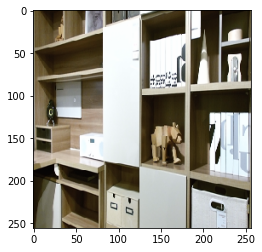

In [144]:
plt.imshow(np.array(real)[342].reshape(256, 256, 3))
plt.savefig('inp6')

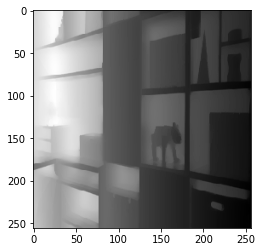

In [143]:
plt.imshow(np.array(targets)[342].reshape(256, 256), cmap='gray')
plt.savefig('tar6')

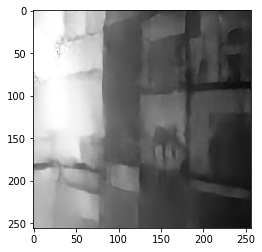

In [142]:
plt.imshow(np.array(generator(np.expand_dims(np.array(real)[342], axis=0))).reshape(256, 256), cmap='gray')
plt.savefig('pred6')

In [61]:
generator.load_weights('weights/depth-gen-weights.h5')

In [126]:
def display_image(images:list, display=True, save=False, name=None):
  import cv2
  import numpy as np
  from matplotlib import pyplot as plt

  img1, img2, img3, *_ = images
    
    
  img1 = np.array(img1).astype(np.float32)
  img2 = np.array(img2).astype(np.float32) 
  img3 = np.array(img3).astype(np.float32) 
    

  img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
  img3 = cv2.cvtColor(img3, cv2.COLOR_GRAY2BGR)

  im_h = cv2.hconcat([img1, img2, img3])
  
  im_h = tf.nn.relu(im_h).numpy()
    
  print(np.max(im_h))   
  print(np.min(im_h))

  plt.xticks([])
  plt.yticks([])

  if display:
    plt.imshow(im_h)

  if save:
    if name is not None:
      plt.imsave(name, im_h.astype(np.float32))
    else:
      raise AttributeError('plt.imsave expected to have a name to save the image')

  return im_h

1.0
0.0


array([[[0.42745098, 0.41568628, 0.37254903],
        [0.44705883, 0.4117647 , 0.3019608 ],
        [0.34117648, 0.28627452, 0.15294118],
        ...,
        [0.16472293, 0.16472293, 0.16472293],
        [0.16313781, 0.16313781, 0.16313781],
        [0.14819048, 0.14819048, 0.14819048]],

       [[0.42745098, 0.42352942, 0.39607844],
        [0.44313726, 0.4117647 , 0.2901961 ],
        [0.3529412 , 0.29411766, 0.16078432],
        ...,
        [0.10876392, 0.10876392, 0.10876392],
        [0.15986148, 0.15986148, 0.15986148],
        [0.16374068, 0.16374068, 0.16374068]],

       [[0.43137255, 0.42352942, 0.4117647 ],
        [0.4509804 , 0.41568628, 0.3137255 ],
        [0.36078432, 0.29411766, 0.15294118],
        ...,
        [0.12211696, 0.12211696, 0.12211696],
        [0.11953734, 0.11953734, 0.11953734],
        [0.11864995, 0.11864995, 0.11864995]],

       ...,

       [[0.13333334, 0.10980392, 0.04313726],
        [0.16470589, 0.13333334, 0.05098039],
        [0.18039216, 0

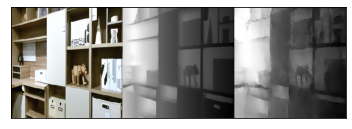

In [145]:
index = 342

inp = np.array(real)[index].reshape(256, 256, 3)
tar = np.array(targets)[index].reshape(256, 256)
gen = np.array(generator(np.expand_dims(np.array(real)[index], axis=0))).reshape(256, 256)

display_image([inp, tar, gen], save=True, name='d6.png')
